In [2]:
from nilmtk import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
ds = DataSet("/data/refit/refit.h5")

In [4]:
len(ds.buildings)

20

In [5]:
elec = ds.buildings[1].elec

In [6]:
def appliance_in_elec(elec, appliance):
    elec_appliances = elec.appliances
    for appl in elec_appliances:
        if appl.type['type']==appliance:
            return True
    return False

In [7]:
appliance_in_elec(elec,'ac')

False

In [8]:
out = {}
appliance_list=["television", "washing machine","microwave"]
for num, building in ds.buildings.items()[:]:
    print num
    elec = building.elec
    mains = elec.mains()
    mains_df = mains.load(sample_period=60).next()['2014-5-1':'2015-4-30']
    aggregate_monthly = mains_df.resample("1M",how="sum").values.flatten()
    
    if len(aggregate_monthly)<12:
        continue
        
        
    mains_df_15min = mains_df.resample("15T")
    diff_15min = mains_df_15min.diff().dropna()
    abs_diff_15min = diff_15min.abs()
    tot = len(abs_diff_15min)
    lt_500 = 1.*(abs_diff_15min<500).sum()/tot
    bet_500_1000 = 1.*((abs_diff_15min>=500)&(abs_diff_15min<1000)).sum()/tot
    gt_1000 = 1.*(abs_diff_15min>=1000).sum()/tot
    mains_df_15min["day"] = mains_df_15min.index.dayofweek
    mains_daywise = mains_df_15min.groupby("day").mean().values.flatten()
    
    
    appliance_power = {k:np.array([np.NaN]*12) for k in appliance_list}
    for appliance_name in appliance_list:
        if appliance_in_elec(elec, appliance_name):
            power_ser = elec[appliance_name].load(sample_period=60).next()
            if len(power_ser):
                power_ser = power_ser[('power','active')]['2014-5-1':'2015-4-30']
                power_ser_monthly = power_ser.resample("1M", how="sum")
                if len(power_ser_monthly)<12:
                    pass
                else:
                    appliance_power[appliance_name] = power_ser.resample("1M", how="sum").values.flatten()
    
    
    out[num] = np.hstack([aggregate_monthly, appliance_power['television'],
                          appliance_power['washing machine'], appliance_power['microwave'],
            
            mains_daywise, lt_500.values, bet_500_1000.values, gt_1000.values])
    

1
10
11
12
13
14
15
16
17
18
19
2
20
3
4
5
6
7
8
9


In [9]:
cols = np.hstack([
        ["aggregate_%d" %i for i in range(1,13)],
        ["television_%d" %i for i in range(1,13)],
        ["washing machine_%d" %i for i in range(1,13)],
        ["microwave_%d" %i for i in range(1,13)],
        ["daily_usage_%d" %i for i in range(1,8)],
        "lt_500","bet_500_1000","gt_1000"
        
        
    ])

In [10]:
len(cols)

58

In [11]:
out_df = pd.DataFrame(out).T
out_df.columns = cols

In [12]:
out_df

aggregate_1      aggregate_2      aggregate_3      aggregate_4  \
1   14327959.898135  14999887.254566  15726860.860676  14791447.871570   
2   18118328.293071  16507026.444364  15205571.363617  12779111.088590   
3   29180664.151798  26584900.142782  21229109.122117  26794917.018685   
4   15273771.287337  15074216.097991  15981309.382401  15394938.534465   
5   29836554.549903  27185211.215595  24399312.861834  27905365.658904   
6   19744410.078364  19825172.773522  19067274.849365  20221613.988831   
7   20475467.555486  19295723.863922  14348923.261330  17328116.928577   
8   25014523.159478  25222884.132026  21533203.619107  27242231.520306   
9   25465079.207291  22205044.472549  22472384.624802  18417248.533053   
10  30774956.297147  26588001.240510  23444211.269261  24860029.772126   
12  15255606.380072  13637148.692769  14756203.661302  13499589.788738   
13  22424846.540162  21729538.588955  17770572.381074  23034503.881313   
14  13337979.256087  10984456.380123  10117785.073984  11585958.052171   
15  27337959.227880  22626466.995402   9260611.083125  17426891.844553   
16  12637486.550080  16054767.679192  15145707.152127  16926828.902647   
17  17308873.937879  20428133.519376  19546511.219377  16217674.850784   
18  11755831.972751  11978195.271217  10942569.463769  10008004.715813   
19  12019260.228461  16044826.261345  15701140.206421  15417930.492880   
20  25066492.850870  25089648.096771  25114906.442102  38013641.183589   

        aggregate_5      aggregate_6      aggregate_7      aggregate_8  \
1   14724811.771606  15313075.854533  17187457.467912  25610878.015243   
2   17930861.507383  20045606.323493  16535853.590807  28505354.242424   
3   23810886.382585  26257199.593056  26142326.339683  39126087.125740   
4   15923910.711665  16042756.389509  15838443.979685  16815375.820865   
5   32683933.055690  37369146.399377  34337660.893277  42316522.561905   
6   17874199.275226  20678737.610961  18353466.391486  20901944.058423   
7   20271585.529321  22553173.340407  28555728.786106  31872473.882901   
8   24634048.686728  24643787.981675  34079587.049839  35595073.710155   
9   24457989.637329  24081889.975264  28349574.460893  33694189.348142   
10  28570621.473511  24118094.020955  25669750.698918  36073779.057930   
12  14983878.953363  15005012.867852  18504374.623124  19296365.890079   
13  12347640.134796  22500931.625252  20384863.272475  19657532.020738   
14   9810937.954116  12130103.528869   9222970.427300  10097003.190548   
15  22848188.019722  25352071.678132  16393845.133694  28547027.493506   
16  16692863.781428  18680295.019623  18421620.157308  20067647.124297   
17  21179936.408963  19263117.075761  16963068.880547  21643892.843326   
18  11733162.416309  14483355.153265  15782302.986183  13513705.042821   
19  18955867.325853  16553876.034419  17557995.675802  17987582.259798   
20  19818056.889646  19672488.465699  19711805.593532  13405713.704346   

        aggregate_9     aggregate_10    ...     daily_usage_1  daily_usage_2  \
1   23035563.084546  26840826.063370    ...        429.876534     444.074334   
2   32524468.544740  23328588.870580    ...        519.769347     469.616168   
3   35778876.697604  30943945.922944    ...        695.936262     780.482847   
4   17660664.920305  15167496.676082    ...        356.815564     369.081089   
5   44448714.696533  34486390.874495    ...        703.472344     686.241499   
6   23284794.533253  19253023.868254    ...        454.996080     473.868719   
7   30137866.926752  23376300.777417    ...        560.599823     494.031754   
8   33549150.546776  31246456.372980    ...        612.025609     668.982420   
9   30098427.818161  24641348.533189    ...        535.184236     489.444320   
10  37038234.675727  31194941.063023    ...        678.716422     672.392818   
12  19124160.091406  18014458.389971    ...        401.943314     372.875809   
13  21387326.718601  24043793.130556    ...        626.182227     530.532359   
14  10

### Contribution of different appliances to overall energy consumption

In [23]:
contri = {}
sum_aggregate = out_df[["aggregate_%d" %i for i in range(1,13)]].sum(axis=1)
for appliance in ["washing machine","television","microwave"]:
    appliance_sum = out_df[["%s_%d" %(appliance,i) for i in range(1,13)]].sum(axis=1)
    contri[appliance] = appliance_sum.div(sum_aggregate).mul(100)

In [25]:
pd.DataFrame(contri).describe()

microwave  television  washing machine
count  15.000000   18.000000        18.000000
mean    2.027520    4.678206         3.637417
std     1.977230    2.900819         1.607737
min     0.385931    0.732937         1.290675
25%     0.793489    2.026579         2.479374
50%     1.395405    4.399562         3.413949
75%     2.391399    7.372888         4.673834
max     7.564291    9.299453         7.233471

In [31]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import LeaveOneOut
k=3
appliance="television"
features_list = ["aggregate_1"]
results = {}
appliance_df = out_df.ix[out_df[["%s_%d" %(appliance, i) for i in range(1,13)]].dropna().index]
print len(appliance_df)
for month in range(1, 13):
    print month
    appliance_col_month = appliance+"_"+str(month)
    results[month] = {}
    clf = KNeighborsRegressor()
    loo = LeaveOneOut(len(appliance_df))
    for train, test in loo:
        clf.fit(appliance_df[features_list].values[train], appliance_df[appliance_col_month].values[train])
        results[month][appliance_df.index[test][0]] = clf.predict(appliance_df[features_list].values[test])[0]

18
1
2
3
4
5
6
7
8
9
10
11
12


In [32]:
pd.DataFrame(results)

1               2               3               4   \
1    745428.496651   776839.433510   809141.391031   689742.801075   
2   1000730.418142  1146612.021716  1048368.458940   906580.241791   
3   1483839.230298  1353969.468797  1258052.308486  1378512.047284   
4    691276.722609   720371.174464   746645.776510   619883.105151   
5   2249987.300632  1568566.147465  1220947.058800  1417137.561743   
6    679668.925329   792866.443505   710651.502971   560124.553997   
7    913761.068195  1034940.598159   964179.833447   870977.891001   
8   1709490.851069  1087811.044188   715568.545364   938661.851955   
9   1615491.648025  1053654.046162   650349.875653   960457.576857   
10  1808380.519983  1181239.876388   950760.145405  1234427.634650   
13   898858.841432  1006971.330425   904067.965756   843090.343282   
14   657790.432931   723546.015379   734092.546117   606236.050107   
15  1508095.257500  1010377.955222  1015150.372949  1131804.156682   
16   629852.602513   676318.615406   685781.669441   616998.337965   
17   726281.421872   822721.926580   755849.560363   661684.187388   
18   651876.871003   724053.318722   750610.449460   642528.344276   
19   696040.801230   704198.874690   746363.731671   625926.720383   
20  1890209.757856  1326573.409143   894284.492767  1147491.892669   

                5               6               7               8   \
1    702567.927908   797963.188855   779024.005244   745528.815443   
2   1085465.283346  1016194.881981  1014615.950293   948929.579219   
3   1347687.761655  1258994.098662  1036387.238753  1210296.738335   
4    782554.402029   787672.858862   683410.515942   685224.179715   
5   1664492.307611  1462619.275561  1317017.871769  1579316.354468   
6    728119.058297   634508.460151   721171.226744   770034.257319   
7    980616.893548   940569.056955   939449.892535   939638.469413   
8   1174642.872966  1037934.000123   960981.758624  1188492.422887   
9   1144707.390411  1015952.826270   974382.581176  1146357.854820   
10  1292501.380501  1207734.782575  1048960.519987  1215244.182060   
13   927581.042669   834157.173902   889612.269035   862712.548809   
14   618161.649552   691276.553004   720111.097271   668634.296741   
15  1067108.675939   972959.204006  1031010.266437  1084860.829289   
16   663301.168250   686216.731819   705438.399915   687640.949335   
17   707860.390616   689764.669571   719255.066358   595784.424551   
18   660994.414951   724513.396676   706804.654658   662073.309025   
19   636264.295799   695978.658358   685563.161549   588779.962145   
20  1349381.619067  1154466.212137  1156309.005110  1388463.219694   

                9               10              11              12  
1    704148.463116   605971.692590   568060.747636   521590.652586  
2    996045.422302   789444.409286   879718.698819   730440.647311  
3   1446383.588140  1312094.385120  1216176.511880   968330.493258  
4    804776.809328   701269.477996   816457.805731   698435.616709  
5   1774257.034562  1596493.201094  1513958.828250  1270988.190119  
6    720575.246180   554176.969324   660130.413478   606823.391983  
7   1151840.491043   990109.504995   949280.336532   824149.229199  
8   1365913.041468  1231782.747284  1147548.704698   960772.773340  
9   1350994.678987  1291934.421851  1098505.753310   910035.848452  
10  1344818.057909  1206942.744781  1168715.535369   973062.981580  
13  1022912.419196   973303.773367   850947.872568   705004.120589  
14   574996.690477   497328.209978   499662.511095   465105.069306  
15  1051582.850618  1007338.725459   957086.974067   910015.579765  
16   612502.442999   493117.500361   440830.848504   406026.778094  
17   657969.538592   559666.021784   528679.853271   407541.076532  
18   633151.179818   570375.134401   533132.232037   470237.891312  
19   593858.135483   563864.801400   556300.266174   463440.797492  
20  1572419.905731  1435020.556638  1306384.374800  1088873.574570

In [28]:
["%s_%d" %(appliance, i) for i in range(1,13)]

['microwave_1',
 'microwave_2',
 'microwave_3',
 'microwave_4',
 'microwave_5',
 'microwave_6',
 'microwave_7',
 'microwave_8',
 'microwave_9',
 'microwave_10',
 'microwave_11',
 'microwave_12']

In [64]:
home =7
new_df = pd.DataFrame({"pred":predictions.ix[home], "gt": tv_df.ix[home]})

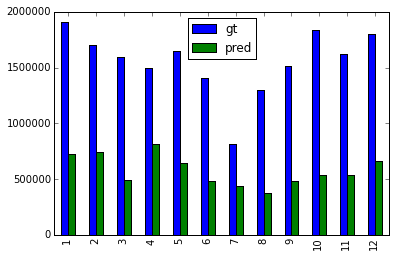

In [65]:
new_df.plot(kind="bar")

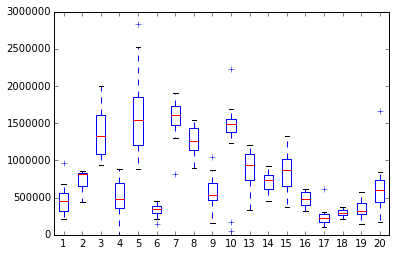

In [68]:
tv_df.T.plot(kind="box")

### TV usage by hour of day

In [70]:
overall_tv_timeseries = {}
for building_num, building in ds.buildings.iteritems():
    try:
        overall_tv_timeseries[building_num] = building.elec['television'].load(sample_period=60).next()[('power','active')]['2014-3-1':'2015-2-28']
    except:
        pass

In [71]:
overall_tv_df = pd.DataFrame(overall_tv_timeseries)

In [80]:
tv_diff = overall_tv_df.diff()

In [81]:
tv_diff_abs = tv_diff.abs()


In [83]:
tv_diff_abs[tv_diff_abs>5].describe()

1            2             3             4             5   \
count   9921.000000  4298.000000   5564.000000  43302.000000  16429.000000   
mean      30.938011    45.865795    126.608528     13.750463     40.044766   
std      343.373552   317.393004    800.860110    129.558376    614.891977   
min        5.000000     5.058333      5.047619      5.000000      5.000000   
25%        6.083333    11.000000     25.316993      6.411765      6.527778   
50%        8.000000    18.433036     55.642361      8.424242      8.972222   
75%       14.888889    27.833333     93.783333     12.000000     14.294118   
max    10922.333333  9830.100000  28086.000000  17475.733333  29490.300000   

                 6             7             8             9             10  \
count   5427.000000   6652.000000   6461.000000  28006.000000  11372.000000   
mean      83.606666     59.675439    122.030447     11.884639     38.829141   
std      461.448942    550.881774    933.091365     22.653178    292.627430   
min        5.006061      5.005682      5.000000      5.003268      5.009804   
25%        8.068056      7.190972     12.000000      6.322222      7.337798   
50%       15.200000     11.931944     25.769231      8.222222     11.886409   
75%       55.760417     21.511458     74.916667     11.889805     24.657576   
max    10925.233333  16639.250000  32767.000000   2278.000000  14745.600000   

                 13            14            15            16           17  \
count   2452.000000   2621.000000  63029.000000  34783.000000  5575.000000   
mean     183.212530    105.027455     21.464842     15.349941    44.985530   
std     1579.185032    832.924237    180.001768    129.153172   257.586252   
min        5.027778      5.130252      5.006536      5.000000     5.000000   
25%        9.220238     15.500000      7.438503      5.888889     7.008303   
50%       18.000000     30.666667     11.000000      7.333333    14.714286   
75%       44.861607     47.700000     18.111111     10.750000    34.755952   
max    49173.750000  21844.666667  24575.250000   9905.000000  6385.100000   

                 18            19            20  
count   5779.000000   8076.000000   5675.000000  
mean      81.283411     60.319938     31.783709  
std      618.215166    420.672041    467.280683  
min        5.000000      5.000000      5.000000  
25%        7.621324      7.700000      5.907260  
50%       11.696429     12.897802      7.309524  
75%       26.698214     26.929762     10.706439  
max    19734.600000  13653.111111  19643.200000

In [43]:
predictions = pd.DataFrame(results)
error = predictions-tv_df
abs_error = error.abs()
frac_error = abs_error.div(tv_df)
acc = (1-frac_error)*100.0

#acc = (100-((pd.DataFrame(results)-wash_df).abs().div(wash_df)))
acc[acc<0]=0
print acc.median().mean()
print acc.mean().mean()

63.5190168135
57.8829773904


### Applying SFS

In [26]:
def criterion_function(feature_set):
    
    
    temp = create_predictions(appliance, feature_set, k)
    errors = {}
    for i in range(1, 13):
        errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
    error_df = pd.DataFrame(errors)
    accur_df = 100-error_df
    accur_df[accur_df<0]=0
   
    if appliance is "hvac":
         tdf = accur_df[range(5, 11)]
    else:
        tdf = accur_df
    #print tdf.dropna().median().mean(), feature_set
    return tdf.dropna().median().mean()

In [52]:
wash_df_norm

Timestamp  2013-09-30  2013-10-31  2013-11-30  2013-12-31  2014-01-31  \
1            0.000000    0.079272    0.139950    0.250708    0.175119   
2            0.130289    0.283359    0.000000    0.013313    0.000000   
3            0.059457    0.142387    0.456296    0.462241    0.362525   
4            0.000000    0.070748    0.180700    0.177749    0.092719   
5            0.054061    0.224009    0.379309    0.302850    0.271341   
6            0.000000    0.000000    0.019057    0.124581    0.143815   
7            0.000000    0.000000    0.550003    0.662811    0.473111   
8            0.000000    0.000000    0.470518    0.529534    0.301943   
9            0.000000    0.000000    0.000000    0.091686    0.194634   
10           0.000000    0.000000    0.269682    0.697411    0.556292   
11           0.000000    0.000000    0.000000    0.000000    0.000000   
13           0.000000    0.000000    0.000000    0.000000    0.081745   
14           0.000000    0.000000    0.000000    0.061911    0.319644   
15           0.000000    0.000000    0.000000    0.000000    0.208330   
16           0.000000    0.000000    0.000000    0.000000    0.000000   
17           0.000000    0.000000    0.000000    0.000000    0.000000   
18           0.000000    0.000000    0.000000    0.000000    0.000000   
19           0.000000    0.000000    0.000000    0.000000    0.000000   
20           0.000000    0.000000    0.000000    0.000000    0.000000   

Timestamp  2014-02-28  2014-03-31  2014-04-30  2014-05-31  2014-06-30  \
1            0.000000    0.075032    0.156236    0.115071    0.112019   
2            0.037254    0.302799    0.295922    0.290607    0.235867   
3            0.000000    0.387506    0.705844    0.435099    0.501994   
4            0.043286    0.000000    0.281192    0.144601    0.314630   
5            0.105043    1.000000    0.539245    0.364797    0.325656   
6            0.000000    0.105145    0.158602    0.077196    0.125823   
7            0.000000    0.564324    0.530446    0.584274    0.496988   
8            0.000000    0.422754    0.544624    0.523272    0.508399   
9            0.000000    0.056879    0.166861    0.311224    0.158416   
10           0.119624    0.015748    0.789144    0.552524    0.552871   
11           0.000000    0.000000    0.000000    0.000000    0.081543   
13           0.000000    0.392198    0.426322    0.426169    0.262044   
14           0.067477    0.315167    0.317866    0.260709    0.262689   
15           0.066203    0.416777    0.376248    0.355076    0.251475   
16           0.000000    0.208232    0.112512    0.156590    0.187395   
17           0.000000    0.076035    0.099325    0.103634    0.107147   
18           0.000000    0.096933    0.091075    0.116131    0.133571   
19           0.000000    0.051617    0.113426    0.075448    0.145523   
20           0.000000    0.218136    0.588455    0.285660    0.211405   

Timestamp     ...      2014-10-31  2014-11-30  2014-12-31  2015-01-31  \
1             ...        0.241944    0.199549    0.193154    0.200680   
2             ...        0.289438    0.269127    0.216252    0.295193   
3             ...        0.373976    0.375257    0.691730    0.514515   
4             ...        0.128269    0.116307    0.167285    0.221705   
5             ...        0.482917    0.613911    0.598411    0.445311   
6             ...        0.128966    0.122549    0.091994    0.152166   
7             ...        0.650653    0.572795    0.637858    0.674411   
8             ...        0.318541    0.383242    0.506289    0.466001   
9             ...        0.159021    0.214377    0.371710    0.203429   
10            ...        0.531944    0.507524    0.598159    0.507640   
11            ...        0.103489    0.124594    0.068594    0.140429   
13            ...        0.290979    0.247825    0.340945    0.334850   
14            ...        0.239112    0.160734    0.272225    0.262178   
15            ...        0.284288    0.168613    0.33529

In [45]:
print out_df[features_list].values[train]

print wash_df_norm[month].values[train]

[[  483.40287202]
 [  611.15555819]
 [  382.01927848]
 [ 1020.88409106]
 [  484.8026173 ]
 [  592.74184081]
 [  712.62639314]
 [  683.89280108]
 [  799.76786842]
 [  424.15919524]
 [  739.83243904]
 [  264.39420167]
 [  524.46607184]
 [  470.48950931]
 [  445.56921549]
 [  290.35675563]
 [  350.40223505]
 [  608.02984413]]
[ 0.130289    0.05945666  0.          0.05406146  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [39]:
make_predictions([5])

2013-09-30 00:00:00
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


ValueError: Unknown label type: array([[ 0.130289  ],
       [ 0.05945666],
       [ 0.        ],
       [ 0.05406146],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [35]:
wash_df_norm['2013-09-30 00:00:00'].values[[1,2]]

array([ 0.130289  ,  0.05945666])

In [108]:
from sklearn.cluster import DBSCAN
clf = DBSCAN(min_samples=3)


In [109]:
from sklearn.preprocessing import scale

In [110]:
wash_df_norm = wash_df.div(wash_df.max().max())

In [111]:
clf.fit(wash_df_norm.T)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

In [112]:
clf.labels_

array([ 0, -1, -1,  0, -1,  0, -1, -1,  0, -1,  0,  1,  0,  1,  0,  0,  0,
        0,  1])

In [113]:
import numpy as np

0 r Int64Index([2, 3, 5, 7, 8, 10], dtype='int64')
1 g Int64Index([1, 4, 6, 9, 11, 14, 16, 17, 18, 19], dtype='int64')
2 b Int64Index([13, 15, 20], dtype='int64')


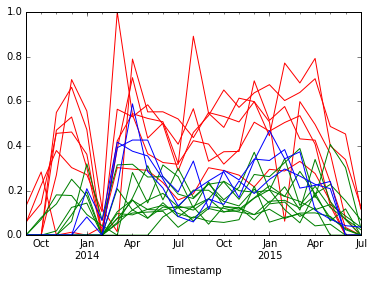

In [213]:
labels = clf.labels_
unique_labels = np.unique(labels)
colors = ['r','g','b','k','y','m','c']
fig = plt.figure()
ax = plt.gca()
for i, l in enumerate(unique_labels):
    
    homes_l = wash_df_norm.columns[np.where(labels==l)[0]]
    print i, colors[i], homes_l
    wash_df_norm[homes_l].plot(legend=False, color=colors[i], ax=ax)

In [95]:
wash_df_norm.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')

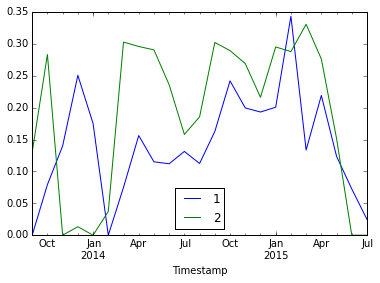

In [100]:
wash_df_norm[[1,2]].plot()

In [135]:
out_df.max().max()

1020.8840910573097

In [136]:
out_df = out_df.div(out_df.max().max())

In [149]:
from sklearn.cluster import DBSCAN
clf_mains = DBSCAN(min_samples=3)

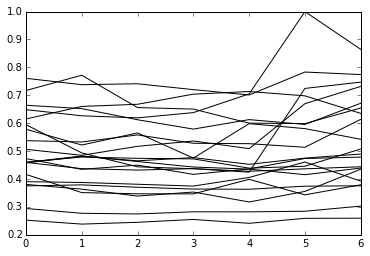

In [140]:
out_df.plot(legend=False, color='k')

In [144]:
out_df.T.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64')

In [164]:
out_df.T[[5]]

5
1   0.445728
2   0.473514
3   0.598653
4   0.374204
5   1.000000
6   0.474885
7   0.580616
8   0.698048
9   0.669902
10  0.783407
11  0.415482
12  0.355561
13  0.724698
14  0.258986
15  0.513737
16  0.460865
17  0.436454
18  0.284417
19  0.343234
20  0.595591

In [196]:
clf_mains = DBSCAN(min_samples=1, eps=0.07, random_state=42)
clf_mains.fit(out_df.T[[6]])

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


DBSCAN(algorithm='auto', eps=0.07, leaf_size=30, metric='euclidean',
    min_samples=1, p=None, random_state=42)

In [197]:
clf_mains.labels_

array([0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 3, 1, 0, 0, 3, 0, 1])

In [220]:
out_df.T.ix[[1,20]]

0         1         2         3         4         5         6
1   0.459969  0.478832  0.474088  0.472123  0.438917  0.445728  0.507619
20  0.664304  0.652317  0.612390  0.578863  0.612863  0.595591  0.671493

In [224]:
for label in np.unique(clf_mains.labels_):
    homes = out_df.T.index[np.where(clf_mains.labels_==label)[0]]
    print label, homes
    print out_df.T.ix[homes][[5]]
    

0 Int64Index([1, 2, 4, 6, 7, 11, 12, 16, 17, 19], dtype='int64')
           5
1   0.445728
2   0.473514
4   0.374204
6   0.474885
7   0.580616
11  0.415482
12  0.355561
16  0.460865
17  0.436454
19  0.343234
1 Int64Index([3, 8, 9, 10, 13, 15, 20], dtype='int64')
           5
3   0.598653
8   0.698048
9   0.669902
10  0.783407
13  0.724698
15  0.513737
20  0.595591
2 Int64Index([5], dtype='int64')
   5
5  1
3 Int64Index([14, 18], dtype='int64')
           5
14  0.258986
18  0.284417


0 r Int64Index([2, 3, 5, 7, 8, 10], dtype='int64')
1 g Int64Index([1, 4, 6, 9, 11, 14, 16, 17, 18, 19], dtype='int64')
2 b Int64Index([13, 15, 20], dtype='int64')


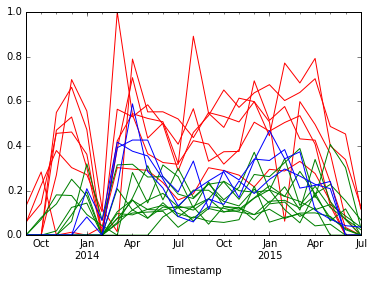

In [186]:
labels = clf.labels_
unique_labels = np.unique(labels)
colors = ['r','g','b','k','y','m','c']
fig = plt.figure()
ax = plt.gca()
for i, l in enumerate(unique_labels):
    
    homes_l = wash_df_norm.columns[np.where(labels==l)[0]]
    print i, colors[i], homes_l
    wash_df_norm[homes_l].plot(legend=False, color=colors[i], ax=ax)

In [211]:
from sklearn.neighbors import NearestNeighbors
kn = NearestNeighbors(n_neighbors=5)
kn.fit(wash_df_norm.T)
dist, nghbr = kn.kneighbors()
nghbr

array([[ 5,  3, 14, 17,  8],
       [11, 13, 18, 14,  8],
       [ 7,  6,  9,  4, 11],
       [ 0,  5, 17,  8, 16],
       [ 6,  2,  7, 11,  9],
       [16, 17, 10, 15,  0],
       [ 2,  7,  4,  9, 12],
       [ 2,  6,  9, 11, 13],
       [ 3, 14,  0, 12,  5],
       [ 2,  7,  6, 12,  8],
       [16, 17, 15,  5, 14],
       [13, 18,  1, 12,  8],
       [ 8, 13, 11, 18,  1],
       [11,  1, 12, 18,  8],
       [17, 16,  5,  0, 15],
       [16, 17, 10,  5, 14],
       [15, 17, 10,  5, 14],
       [16, 10,  5, 15, 14],
       [11,  1, 13, 14,  3]])

In [212]:
from sklearn.neighbors import NearestNeighbors
kn_mains = NearestNeighbors(n_neighbors=5)
kn.fit(out_df.T[[6]])
dist, nghbr = kn.kneighbors()
nghbr

array([[ 5,  1,  6, 16, 10],
       [ 5,  0, 16, 10, 11],
       [19,  7, 14,  8, 12],
       [18, 15, 11, 10, 16],
       [ 9, 12,  8, 19,  2],
       [ 1,  0, 16, 10,  6],
       [ 0,  5,  1, 14,  7],
       [ 2, 14, 19,  6,  8],
       [12,  9, 19,  2,  7],
       [12,  8,  4, 19,  2],
       [11, 16,  1, 15,  5],
       [10, 16, 15,  1,  5],
       [ 8,  9, 19,  2,  7],
       [17,  3, 18, 15, 11],
       [ 7,  2, 19,  6,  0],
       [18,  3, 11, 10, 16],
       [10, 11,  1,  5, 15],
       [13,  3, 18, 15, 11],
       [ 3, 15, 11, 10, 16],
       [ 2,  7, 14,  8, 12]])

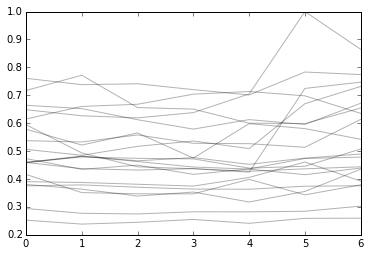

In [157]:
out_df.plot(legend=False, alpha=0.3, color='k')

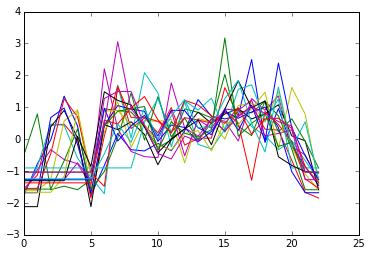

In [65]:
plt.plot(wash_df_norm)

In [8]:
m = elec.mains()

In [9]:
m

ElecMeter(instance=1, building=1, dataset='REFIT', site_meter, appliances=[])

In [10]:
df = m.load(sample_period=60).next()

In [12]:
df_monthly = df.resample("1M",how="sum")

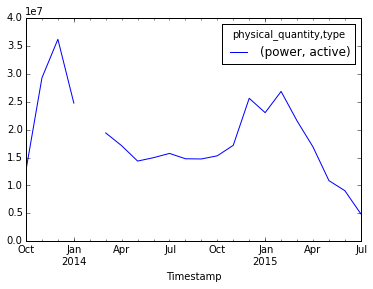

In [14]:
df_monthly.plot()